In [59]:
from pharynx_analysis import (pharynx_io as pio, image_processing as ip, experiment, plots, profile_processing)
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from importlib import reload
from skimage import measure, transform
from collections import namedtuple
import pdb
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import scale
import skimage
import logging
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import seaborn as sns
from skfda import FDataGrid
import skfda
from statsmodels.stats.weightstats import DescrStatsW
from scipy import signal
import matlab.engine
import matlab
import pandas as pd
from pathlib import Path

reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)
reload(profile_processing)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [66]:
data = xr.load_dataarray('/Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47/2017_02_22-HD233_SAY47-profile_data_reg.nc')

In [63]:
meta_dir = Path("/Users/sean/code/wormAnalysis/data/paired_ratio/")
imaging_scheme = "TL/470/410/470/410"

dfs = []
for table in meta_dir.glob('**/*summary*.csv'):
    dfs.append(pd.read_csv(table))
df = pd.concat(dfs)
df['strategy'] = 'cata'
df
df.to_csv('/Users/sean/Desktop/all_cata.csv', index=False)

In [60]:
meta_dir = Path("/Users/sean/code/wormAnalysis/data/paired_ratio/")
imaging_scheme = "TL/470/410/470/410"

for exp_dir in filter(lambda x: x.is_dir(), meta_dir.iterdir()):
    if not 'SKIP' in exp_dir.stem:
        ex = experiment.CataExperiment(
            experiment_dir=exp_dir,
            imaging_scheme=imaging_scheme,
            trim_threshold=4000
        )
        ex.full_pipeline()

09:49:03 INFO:Starting full pipeline run for /Users/sean/code/wormAnalysis/data/paired_ratio/2017_08_23-HD233_4mm_lev
09:49:03 INFO:Loading Images
09:49:03 INFO:Segmenting pharynxes
09:49:04 INFO:Centering and rotating pharynxes
100%|██████████| 28/28 [00:01<00:00, 16.28it/s]
09:49:06 INFO:Calculating midlines
100%|██████████| 28/28 [00:00<00:00, 116.39it/s]
09:49:06 INFO:Measuring under midlines
100%|██████████| 28/28 [00:00<00:00, 32.90it/s]
09:49:07 INFO:Trimming intensity data
09:49:07 INFO:Calculating redox measurements
09:49:08 INFO:Saving 2017_08_23-HD233_4mm_lev inside /Users/sean/code/wormAnalysis/data/paired_ratio/2017_08_23-HD233_4mm_lev
09:49:08 INFO:Saving region means to /Users/sean/code/wormAnalysis/data/paired_ratio/2017_08_23-HD233_4mm_lev/2017_08_23-HD233_4mm_lev-summary_table.csv
09:49:08 INFO:Saving raw profile data to /Users/sean/code/wormAnalysis/data/paired_ratio/2017_08_23-HD233_4mm_lev/2017_08_23-HD233_4mm_lev-profile_data_raw.nc
09:49:08 INFO:Finished full Cat

09:50:58 INFO:Saving region means to /Users/sean/code/wormAnalysis/data/paired_ratio/2017_08_24-HD233_SAY93/2017_08_24-HD233_SAY93-summary_table.csv
09:50:59 INFO:Saving raw profile data to /Users/sean/code/wormAnalysis/data/paired_ratio/2017_08_24-HD233_SAY93/2017_08_24-HD233_SAY93-profile_data_raw.nc
09:50:59 INFO:Finished full Cata pipeline run for /Users/sean/code/wormAnalysis/data/paired_ratio/2017_08_24-HD233_SAY93
09:50:59 INFO:Starting full pipeline run for /Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_27-HD233_HD236
09:50:59 INFO:Loading Images
09:50:59 INFO:Segmenting pharynxes
09:51:03 INFO:Centering and rotating pharynxes
100%|██████████| 120/120 [00:07<00:00, 16.70it/s]
09:51:12 INFO:Calculating midlines
100%|██████████| 120/120 [00:01<00:00, 119.62it/s]
09:51:13 INFO:Measuring under midlines
100%|██████████| 120/120 [00:03<00:00, 32.73it/s]
09:51:16 INFO:Trimming intensity data
09:51:17 INFO:Calculating redox measurements
09:51:17 INFO:Saving 2017_02_27-HD233_HD

In [268]:
experiment_dir = "/Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47"
imaging_scheme = "TL/470/410/470/410"

reload(experiment);
ex = experiment.PairExperiment(
    experiment_dir=experiment_dir,
    imaging_scheme=imaging_scheme,
    trim_threshold=4000
)
ex.full_pipeline()

02:36:41 INFO:Starting full pipeline run for /Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47
02:36:41 INFO:Loading Images
02:36:41 INFO:Segmenting pharynxes
02:36:42 INFO:Centering and rotating pharynxes
100%|██████████| 123/123 [00:07<00:00, 15.90it/s]
02:36:51 INFO:Calculating midlines
100%|██████████| 123/123 [00:01<00:00, 117.60it/s]
02:36:52 INFO:Measuring under midlines
100%|██████████| 123/123 [00:03<00:00, 31.03it/s]
02:36:56 INFO:Registering profiles
02:38:21 INFO:Trimming intensity data
02:38:23 INFO:Calculating redox measurements
02:38:23 INFO:Finished full pipeline run for /Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47


In [64]:
ex

CataExperiment(experiment_dir=PosixPath('/Users/sean/code/wormAnalysis/data/paired_ratio/2017_08_25-HD233_4mm_lev'), imaging_scheme='TL/470/410/470/410', strains=array(['HD233', 'HD233', 'HD233', 'HD233', 'HD233', 'HD233', 'HD233',
       'HD233', 'HD233', 'HD233', 'HD233', 'HD233', 'HD233', 'HD233',
       'HD233', 'HD233', 'HD233', 'HD233', 'HD233', 'HD233', 'HD233',
       'HD233', 'HD233', 'HD233', 'HD233', 'HD233', 'HD233', 'HD233',
       'HD233', 'HD233', 'HD233', 'HD233', 'HD233', 'HD233', 'HD233'],
      dtype='<U5'), experiment_id='2017_08_25-HD233_4mm_lev', raw_image_data=<xarray.DataArray (strain: 35, wavelength: 3, pair: 2, y: 130, x: 174)>
array([[[[[0, ..., 0],
          ...,
          [0, ..., 0]],

         [[0, ..., 0],
          ...,
          [0, ..., 0]]],


        ...,


        [[[0, ..., 0],
          ...,
          [0, ..., 0]],

         [[0, ..., 0],
          ...,
          [0, ..., 0]]]],



       ...,



       [[[[0, ..., 0],
          ...,
          [0

(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12fdcf208>)

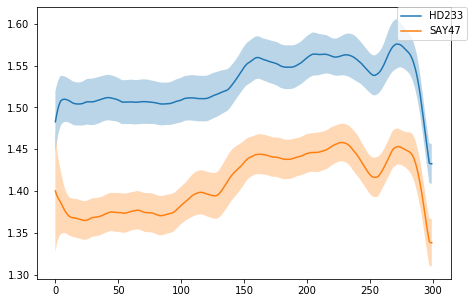

In [269]:
plots.plot_profile_avg_by_strain(ex.trimmed_raw_profiles.sel(wavelength='r', pair=0))

(-0.2, 0.2)

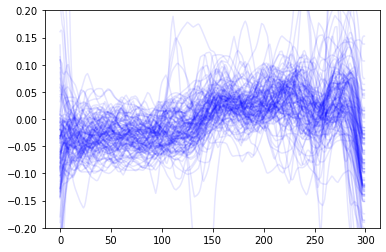

In [25]:
d = ex.trimmed_raw_profiles.sel(wavelength='r', pair=0)
plt.plot((d - np.mean(d, axis=1)).T, color='b', alpha=0.1);
plt.ylim([-0.2, .2])

(-0.2, 0.2)

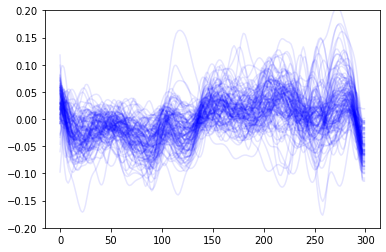

In [26]:
d = ex.trimmed_reg_profiles.sel(wavelength='r', pair=0)
plt.plot((d - np.mean(d, axis=1)).T, color='b', alpha=0.1);
plt.ylim([-0.2, .2])

In [288]:
reg_profile_data = profile_processing.register_profiles(ex.raw_profiles, warp_lambda=1e4)

In [30]:
ex.summary_table['total'] =ex.summary_table.anterior + ex.summary_table.posterior + ex.summary_table.sides_of_tip + ex.summary_table.tip

In [54]:
ex.summary_table[(ex.summary_table.pair==0) & (ex.summary_table.total==0)]
ex.summary_table[(ex.summary_table.pair==1) & (ex.summary_table.total>0)]

,animal,strain,region,experiment,strategy,pair,470,410,r,oxd,e,anterior,posterior,sides_of_tip,tip,total
124,1,HD233,pm3,2017_02_22-HD233_SAY47,raw,1,6153.703356,8613.695256,1.397892,0.377978,-271.336398,1,1,1,1,4
131,8,HD233,pm3,2017_02_22-HD233_SAY47,raw,1,6964.068912,9812.591184,1.410093,0.383759,-271.024022,0,0,2,1,3
133,10,HD233,pm3,2017_02_22-HD233_SAY47,raw,1,6587.614368,9882.202366,1.499435,0.423567,-268.920001,0,2,0,0,2
134,11,HD233,pm3,2017_02_22-HD233_SAY47,raw,1,6739.873664,9608.442505,1.424802,0.390567,-270.659632,1,1,2,2,6
135,12,HD233,pm3,2017_02_22-HD233_SAY47,raw,1,5563.207877,7444.693277,1.337024,0.347937,-272.991645,1,0,1,1,3
141,18,HD233,pm3,2017_02_22-HD233_SAY47,raw,1,5703.534040,8950.383036,1.569266,0.452133,-267.443113,2,2,1,2,7
142,19,HD233,pm3,2017_02_22-HD233_SAY47,raw,1,4691.394448,7023.550446,1.497227,0.422688,-268.964979,0,0,1,1,2
144,21,HD233,pm3,2017_02_22-HD233_SAY47,raw,1,6371.659194,8870.589933,1.392943,0.375593,-271.466043,0,0,0,1,1
158,35,HD233,pm3,2017_02_22-HD233_SAY47,raw,1,6245.170269,8989.186402,1.439618,0.397392,-270.295082,1,1,0,1,3
159,36,HD233,pm3,2017_02_22-HD233_SAY47,raw,1,5294.767529,8169.566700,1.544688,0.442287,-267.950157,0,1,0,1,2


In [42]:
non_movers = ex.summary_table[(ex.summary_table.total == 0) & (ex.summary_table.pair==0) & (ex.summary_table.strategy=='reg')& (ex.summary_table.region=='pm7')].animal
movers = ex.summary_table[(ex.summary_table.total > 0) & (ex.summary_table.pair==0) & (ex.summary_table.strategy=='reg')& (ex.summary_table.region=='pm7')].animal

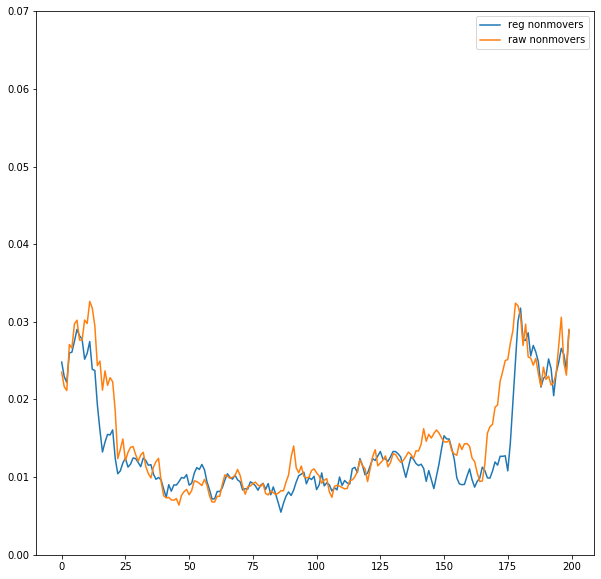

In [49]:
plt.figure(figsize=(10,10))
rr = (ex.reg_profiles.sel(wavelength='410', pair=0) / ex.reg_profiles.sel(wavelength='470', pair=0)) / (ex.reg_profiles.sel(wavelength='410', pair=1) / ex.reg_profiles.sel(wavelength='470', pair=1))
plt.plot(np.median(np.abs(1-rr[non_movers.values]), axis=0), label='reg nonmovers')

rr = (ex.raw_profiles.sel(wavelength='410', pair=0) / ex.raw_profiles.sel(wavelength='470', pair=0)) / (ex.raw_profiles.sel(wavelength='410', pair=1) / ex.raw_profiles.sel(wavelength='470', pair=1))
plt.plot(np.median(np.abs(1-rr[non_movers.values]), axis=0), label='raw nonmovers')
plt.ylim([0, .07])
plt.legend()

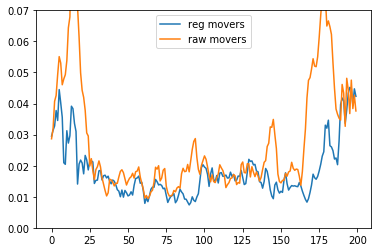

In [55]:
rr = (ex.reg_profiles.sel(wavelength='410', pair=0) / ex.reg_profiles.sel(wavelength='470', pair=0)) / (ex.reg_profiles.sel(wavelength='410', pair=1) / ex.reg_profiles.sel(wavelength='470', pair=1))
plt.plot(np.median(np.abs(1-rr[movers.values]), axis=0), label='reg movers')

rr = (ex.raw_profiles.sel(wavelength='410', pair=0) / ex.raw_profiles.sel(wavelength='470', pair=0)) / (ex.raw_profiles.sel(wavelength='410', pair=1) / ex.raw_profiles.sel(wavelength='470', pair=1))
plt.plot(np.median(np.abs(1-rr[movers.values]), axis=0), label='raw movers')
plt.ylim([0, .07])
plt.legend()

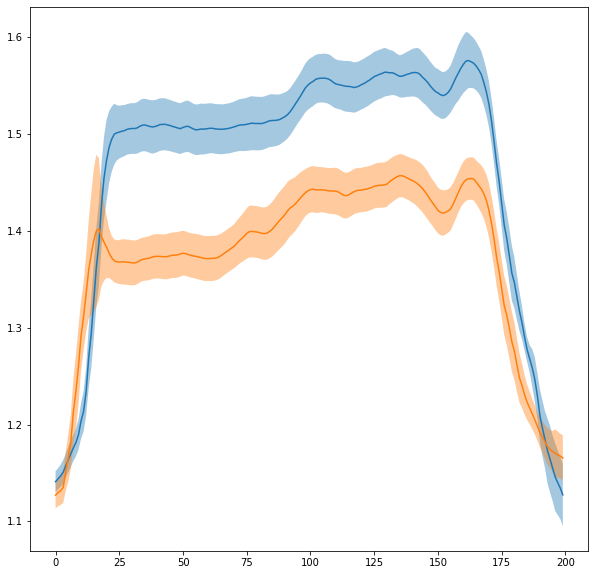

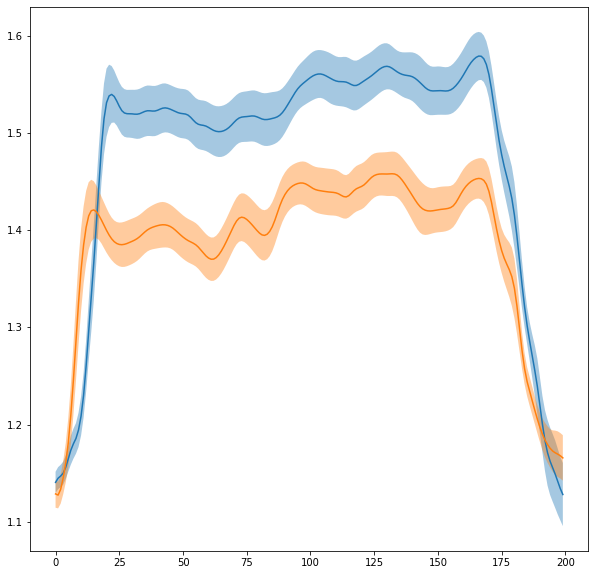

In [302]:
plots.plot_average_by_strain_and_pair(ex.raw_profiles.sel(wavelength='410', pair=0) / ex.raw_profiles.sel(wavelength='470', pair=0))
plots.plot_average_by_strain_and_pair(reg_profile_data.sel(wavelength='410', pair=0) / reg_profile_data.sel(wavelength='470', pair=0))

In [195]:
little_mvmt = (ex.summary_table[(ex.summary_table.pair == 0) & (ex.summary_table.region == 'pm7') & (ex.summary_table.strategy == 'raw')].anterior <= 1).values
lotsof_mvmt = np.logical_not(little_mvmt)

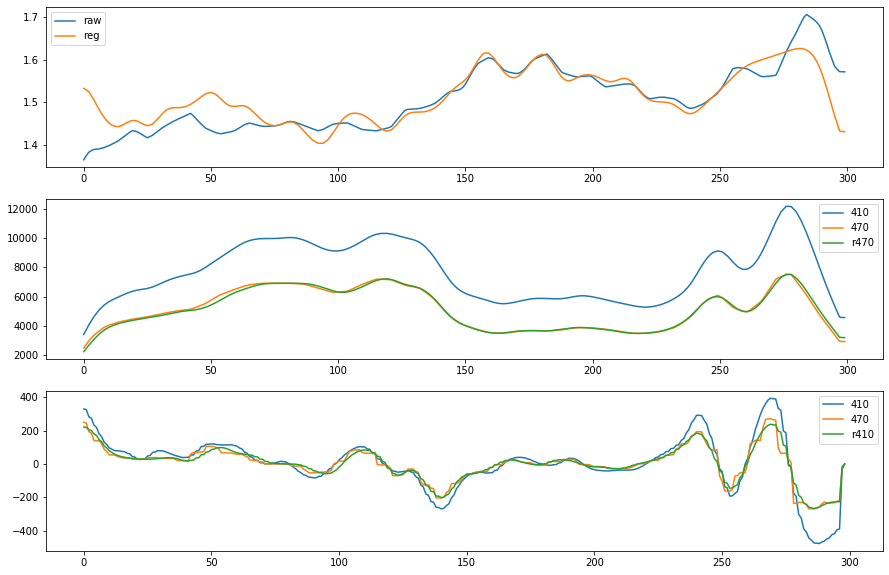

In [277]:
i=i+1
fig, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=(15,10))
ax0.plot(ex.trimmed_raw_profiles.sel(wavelength='r', pair=0).isel(strain=i), label='raw');
ax0.plot(ex.trimmed_reg_profiles.sel(wavelength='r', pair=0).isel(strain=i), label='reg');
ax0.legend()

ax1.plot(ex.trimmed_reg_profiles.sel(wavelength='410', pair=0).isel(strain=i), label='410');
ax1.plot(ex.trimmed_raw_profiles.sel(wavelength='470', pair=0).isel(strain=i), label='470');
ax1.plot(ex.trimmed_reg_profiles.sel(wavelength='470', pair=0).isel(strain=i), label='r470');
ax1.legend();


ax2.plot(np.diff(ex.trimmed_reg_profiles.sel(wavelength='410', pair=0).isel(strain=i)), label='410');
ax2.plot(np.diff(ex.trimmed_raw_profiles.sel(wavelength='470', pair=0).isel(strain=i)), label='470');
ax2.plot(np.diff(ex.trimmed_reg_profiles.sel(wavelength='470', pair=0).isel(strain=i)), label='r410');

ax2.legend();

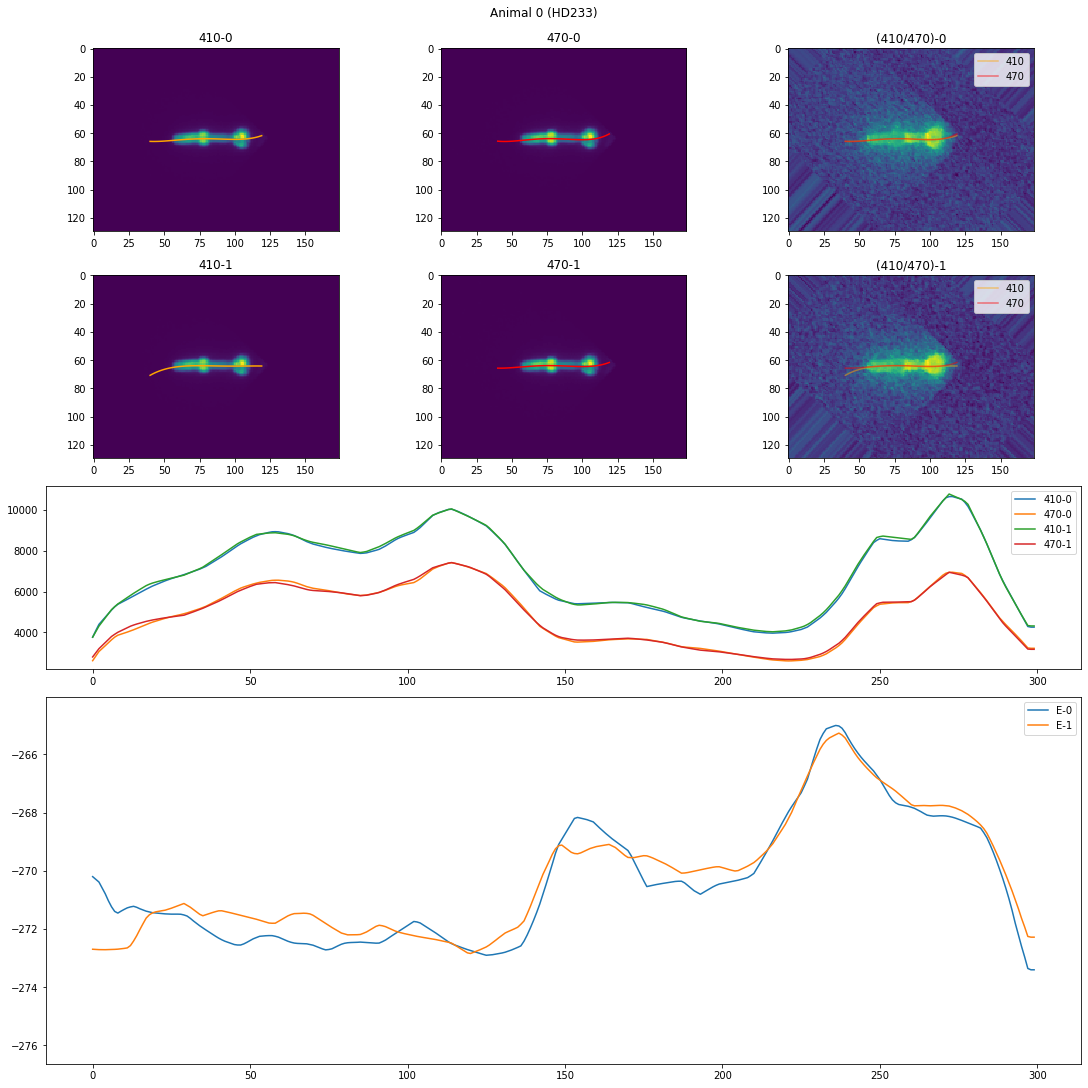

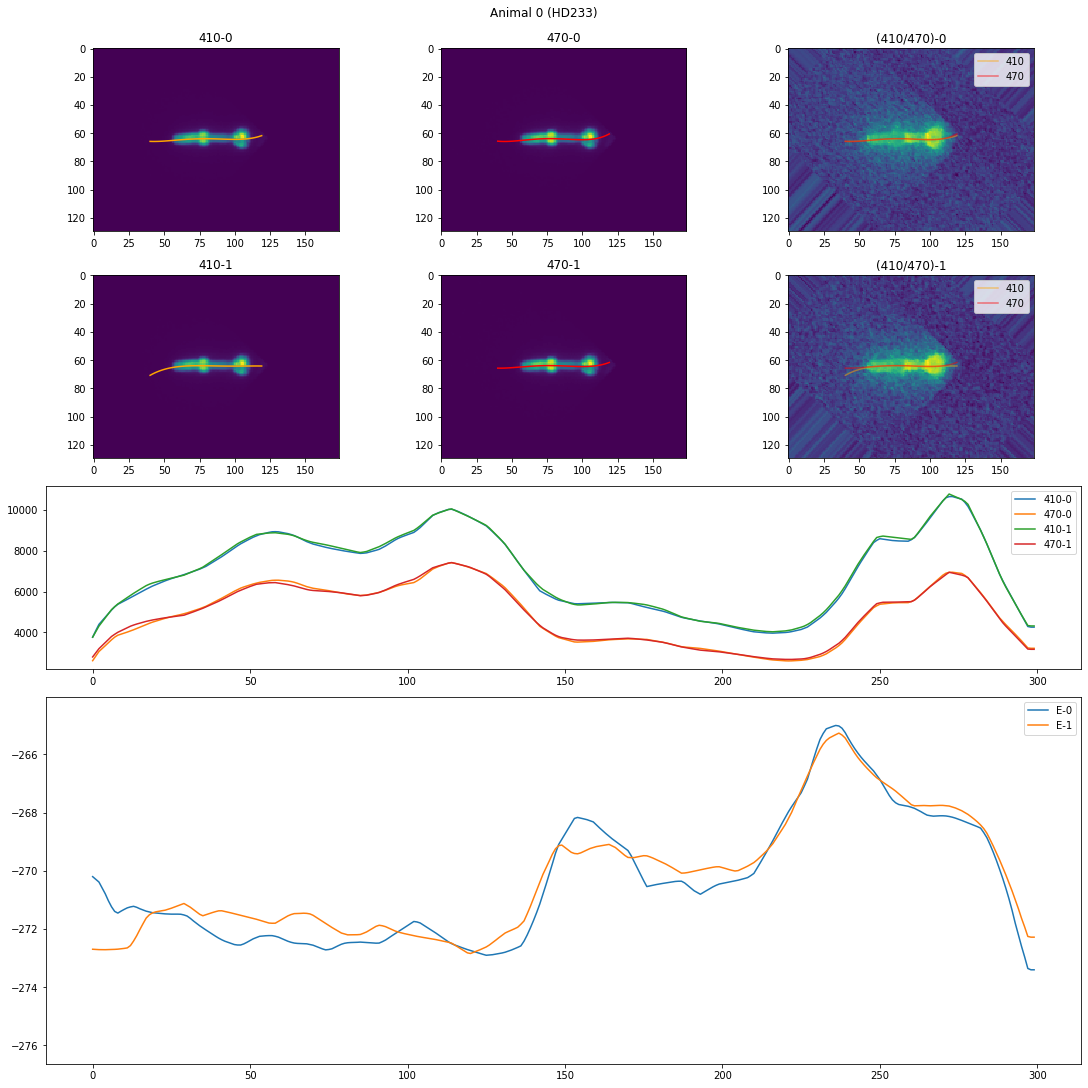